# Recurrent Neural Network


### From Assignment Brief:
The goal of this project is to build a next-word predictor, given a sequence of words. <br>
The input to your model is a sequence of words of any length (could be one word,
could be five words, etc.). <br>
The output of your model is a word that follows that sequence of words. <br>
In principle, given an input to your model, you can ask your model to predict the next
ten words, by asking your model to predict the next word ten times. <br>
To test your model, you must apply the following ten example sequences of words as inputs: <br>
You can ask your model to predict the next ten words, given each input. For example: (Seed text **bolded**) <br><br>
Model 1: <br>
**embrace each day** for morning's potential is a blank canvas seize it with <br>
**radiate some** gratitude and watch as the universe conspires to bring you <br>
**believe that** yourself and let your heart's whispers guide you to your <br>
**life's actual purpose is** a chance to learn to grow and to embrace the <br>
**dance through each and every** one chapter of life to the next world your nature <br>
**let your time and energy** so brightly that it eclipses even the darkest of days <br>
**every person is** of kindness sends ripples of positivity throughout the universe of <br>
**our country Singapore is** through storms knowing that your steps create the path to <br>
**planet earth is** through challenges like a breeze through the trees leaving a <br>
**morning and evening would make it** the chisels that sculpt you into a masterpiece of strength <br>

Model 2:<br>
**embrace each day** they bring the thunder that clears the path to your<br>
**radiate some** positivity illuminating the world with a light that banishes darkness<br>
**believe that** yourself and let your inner light outshine any darkness around<br>
**life's actual purpose is** a wildflower spreading love's fragrance far and wide and majesty<br>
**dance through each and every** from one chapter of life to the next next hues<br>
**let your time and energy** so hold mysteries waiting to be explored revealing hidden wonders<br>
**every person is** you nurture blooms into a garden of meaningful relationships relationships<br>
**our country Singapore is** is a testament to the city's ambition and resilience and<br>
**planet earth is** sparkles a reflection of the city's ambition to reach new<br>
**morning and evening would make it** a tapestry of flavors weaving a story of cultural fusion<br>

In [25]:
seed_texts = [
    'embrace each day',
    'radiate some',
    'believe that',
    "life's actual purpose is",
    'dance through each and every',
    'let your time and energy',
    'every person is',
    'our country Singapore is',
    'planet earth is',
    'morning and evening would make it'
]

In [1]:
import os
from tqdm.notebook import tqdm
import random
import warnings
import re

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable TF Warnings
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["tf_gpu_allocator"]="cuda_malloc_async"
warnings.filterwarnings("ignore")

checkpoint_folder_path = "training_checkpoints/"

# example filepath large_weights.{epoch:02d}-{val_loss:.2f}.hdf5

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', None)

import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

import spacy

nlp = spacy.load("en_core_web_sm")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
!nvidia-smi

Mon Nov 20 19:36:57 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 535.98       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070        On  | 00000000:01:00.0  On |                  N/A |
|  0%   33C    P8               9W / 200W |  11337MiB / 12282MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, ReLU, LeakyReLU, BatchNormalization, Add, Input, concatenate, TextVectorization, Embedding, Bidirectional, Attention, GaussianNoise
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, SimpleRNNCell, StackedRNNCells, LSTMCell, GRUCell, RNN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [5]:
import visualkeras

In [6]:
sns.set(style='darkgrid', palette='deep')

tf.random.set_seed(42)

# Exploratory Data Analysis

The dataset consists of 1000 training text samples.

In [7]:
df = pd.read_csv("data/train.csv")
eda_df = df.copy()

In [8]:
eda_df.head()

,Quotes
0,Embrace the beauty of every sunrise; it's a fresh chance to paint your world with joy.
1,Embrace challenges; they are the stepping stones to your greatest victories.
2,Embrace the rhythm of life and let it dance through your soul.
3,"Embrace kindness, for it has the power to change the world one heart at a time."
4,"Embrace the journey, for it leads to the destination of your dreams."


In [9]:
eda_df.describe()

,Quotes
count,1000
unique,890
top,"Radiate acceptance, and find peace in embracing what is."
freq,5


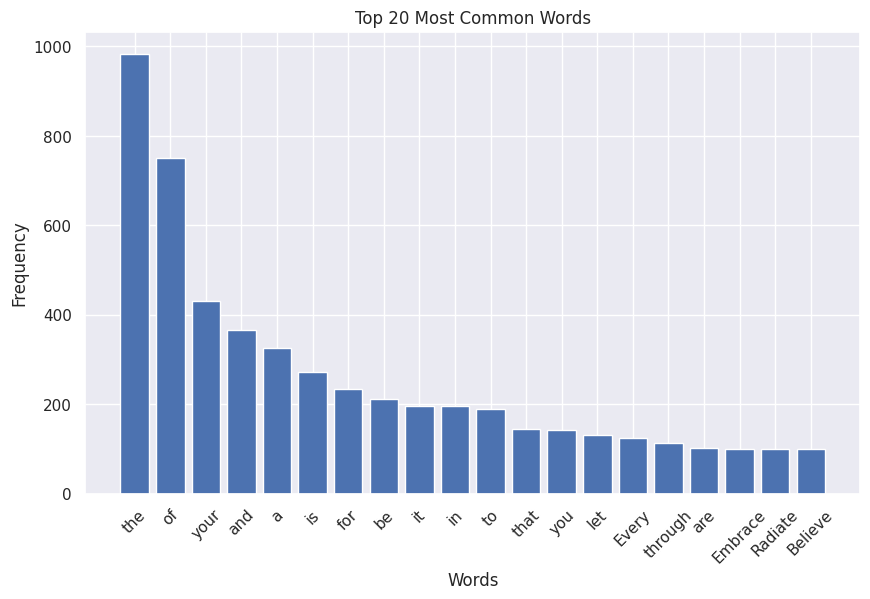

In [10]:
from collections import Counter

# Assuming 'sentences' is a list of sentences in your dataset
words = [word for sentence in eda_df["Quotes"] for word in sentence.split()]
word_freq = Counter(words)
top_20_words = dict(word_freq.most_common(20))

plt.figure(figsize=(10, 6))
plt.bar(top_20_words.keys(), top_20_words.values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Words')
plt.xticks(rotation=45)
plt.show()

In [11]:
sentence_lengths = [len(sentence.split()) for sentence in eda_df["Quotes"]]
print("Average sentence length:", sum(sentence_lengths) / len(sentence_lengths))
print("Maximum sentence length:", max(sentence_lengths))
print("Minimum sentence length:", min(sentence_lengths))

Average sentence length: 11.865
Maximum sentence length: 35
Minimum sentence length: 7


## Preprocessing

In [12]:
train, test = train_test_split(df["Quotes"], test_size=0.2, random_state=23)
train, validation = train_test_split(train, test_size=2/8, random_state=23)

In [13]:
def remove_punctuation(sentence):
    PUNC = [";", ".", ",", ":", "?", "!", "\n", "\t", "'", '"', "-"]
    output = []
    for word in sentence:
        if word not in PUNC:
            output.append(word)
    return output

def keep_joint(sentence, joiner):
    output = [sentence[0]]
    for i, word in enumerate(sentence[1:]):
        if joiner in word:
            output.pop()
            output.append(sentence[i-1]+word)
            print(i, sentence)
        else:
            output.append(word)
    return output

def remove_contractions(sentence):
    contractions = {
        "'s": "is",
        "'ve": "have",
        "'ll": "will"
    }
    output = []
    for word in sentence:
        if word in contractions:
            word = contractions[word]
        output.append(word)
    # print(output)
    return output

def clean_sentences(sentences):
    for i, sentence in enumerate(sentences):
        sentences[i] = remove_punctuation(sentence)
        # sentences[i] = remove_contractions(sentence)
        # sentences[i] = keep_joint(sentences[i], "-")
    return sentences

def clean_sentences_for_input(sentences):
    for i, sentence in enumerate(sentences):
        # sentences[i] = remove_punctuation(sentence)
        sentences[i] = remove_contractions(sentence)
        # sentences[i] = keep_joint(sentences[i], "-")
    return sentences

In [14]:
tokenized_quotes = [[token.text for token in nlp(quote)] for quote in df["Quotes"]]
tokenized_quotes = clean_sentences(tokenized_quotes)

In [15]:
all_words = []

for word in tokenized_quotes:
    all_words += word
    
print(f"Total word count: {len(all_words)}")

# for word in lemmatized_quotes:
#     all_words += word

all_words = list(set(all_words))

Total word count: 12205


In [16]:
for i in range(5):
    print(tokenized_quotes[i])

# for i in range(5):
#     print(lemmatized_quotes[i])
    
tokenizer = Tokenizer(split=" ", lower=True)
tokenizer.fit_on_texts([all_words])

total_words = len(tokenizer.word_index)
print(f"Number of unique words: {total_words}")
total_words += 1

max_sequence_length = 35

['Embrace', 'the', 'beauty', 'of', 'every', 'sunrise', 'it', "'s", 'a', 'fresh', 'chance', 'to', 'paint', 'your', 'world', 'with', 'joy']
['Embrace', 'challenges', 'they', 'are', 'the', 'stepping', 'stones', 'to', 'your', 'greatest', 'victories']
['Embrace', 'the', 'rhythm', 'of', 'life', 'and', 'let', 'it', 'dance', 'through', 'your', 'soul']
['Embrace', 'kindness', 'for', 'it', 'has', 'the', 'power', 'to', 'change', 'the', 'world', 'one', 'heart', 'at', 'a', 'time']
['Embrace', 'the', 'journey', 'for', 'it', 'leads', 'to', 'the', 'destination', 'of', 'your', 'dreams']
Number of unique words: 1180


In [17]:
tokenized_quotes = [[token.text for token in nlp(quote)] for quote in df["Quotes"]]
tokenized_quotes = clean_sentences(tokenized_quotes)

In [18]:
def sentences_to_data(sentences, min_sequence_length, segment, tokenize=True, verbose=0):
    # X_lemma = []
    X_word = []
    y = []

    tokenized_input = [[token.text for token in nlp(quote)] for quote in sentences]
    tokenized_input = clean_sentences(tokenized_input)
    
    # min_sequence_length = 4
    # max_sequence_length = 25
    if segment:
        for sequence in tokenized_input:
            for i in range(len(sequence)):
                for j in range(i+min_sequence_length, len(sequence)):
                    # X_lemma.append(" ".join(sequence[i:j]))
                    X_word.append(" ".join(sequence[i:j]))
                    y.append(sequence[j])
                    if verbose > 0:
                        if len(tokenizer.texts_to_sequences([y[-1]])[0]) != 1:
                            print(y[-1])
    else:
        for sequence in tokenized_input:
            sequence = sequence[:max_sequence_length+1]
            for i in range(min_sequence_length, len(sequence)):
                X_word.append(" ".join(sequence[:i]))
                y.append(sequence[i])
                if verbose > 0:
                    if len(tokenizer.texts_to_sequences([y[-1]])[0]) != 1:
                        print(y[-1])

    sentence_lengths = [len(sentence.split(" ")) for sentence in sentences]
    print("Average sentence length:", sum(sentence_lengths) / len(sentence_lengths))
    print("Maximum sentence length:", max(sentence_lengths))
    print("Longest sentence: ", X_word[np.argmax(sentence_lengths)])
    print("Minimum sentence length:", min(sentence_lengths))

    if tokenize:
        X_word = tokenizer.texts_to_sequences(X_word)
        X_word = pad_sequences(X_word, maxlen=max_sequence_length, padding="pre")
    else:
        X_word = clean_sentences_for_input([sentence.split(" ") for sentence in X_word])
        X_word = [" ".join(sentence) for sentence in X_word]

    y = tokenizer.texts_to_sequences(y)
    
    if verbose > 0:
        for pred, label in zip(X_word[:5], y[:5]):
            print(f"Predictor: {pred}\nLabel: {label}")
    
    y = to_categorical(y, num_classes=total_words)
    y = y.astype(float)
    y = np.array(y)

    X_word = np.array(X_word)

    return X_word, y

In [33]:
def fit_model(model, filepath, batch_size=32, epochs=20,):
    # cp_callback = ModelCheckpoint(filepath=filepath, save_format='tf', save_weights_only=True, save_best_only=True, verbose=1, save_freq='epoch')
    
    history = model.fit(
        X_train, 
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_validation, y_validation),
        # callbacks=[cp_callback]
    )
    
    accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    
    print(f"Accuracy: {accuracy:.2f}")

    return history

def plot_history(history, title, savefig=""):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    fig.suptitle(title)
    
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(['Train', 'Validation'], loc='upper left')
    
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

    if savefig != "":
        fig.savefig(savefig, bbox_inches='tight')

def predict_next_word(model, seed_text, next_words=1):
    for _ in range(next_words):
        seed_text = [token.text for token in nlp(seed_text)]
        seed_text = " ".join(clean_sentences_for_input(clean_sentences([seed_text]))[0])

        # print(seed_text)
        
        # token_list = tokenizer.texts_to_sequences([seed_text])[0]
        # token_list = pad_sequences([token_list], maxlen=max_sequence_length, padding='pre')
        model_prediction = model.predict([seed_text], verbose=0)
        sorted_indices = sorted(range(len(model_prediction)), key=lambda k: model_prediction[k])
        sorted_array = [model_prediction[i] for i in sorted_indices]

        for token, original_index in zip(sorted_array[:5], sorted_indices[:5]):
            for word, index in tokenizer.word_index.items():
                if token ==:
                    print(word, original_index)
        
        predicted_index = np.argmax(model_prediction, axis=-1)
        predicted_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                predicted_word = word
                break
        seed_text += " " + predicted_word
    return seed_text

### Tokenizer

In [287]:
# X_train, y_train = sentences_to_data(train, 2, True, verbose=1)
# X_test, y_test = sentences_to_data(test, 4, False, verbose=1)
# X_validation, y_validation = sentences_to_data(validation, 4, False, verbose=1)

Average sentence length: 11.8
Maximum sentence length: 34
Longest sentence:  's rainforests are the lungs that breathe life into
Minimum sentence length: 7
Predictor: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  18 655]
Label: [362]
Predictor: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0  18 655 362]
Label: [1001]
Predictor: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0   18  655  362 1001]
Label: [644]
Predictor: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0   18  655  362 1001  644]
Label: [9]
Predictor: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0   

### TextVectorization

In [20]:
random.seed(42)


X_train, y_train = sentences_to_data(train, 3, True, tokenize=False, verbose=1)
X_test, y_test = sentences_to_data(test, 3, True, tokenize=False, verbose=1)
X_validation, y_validation = sentences_to_data(validation, 3, True, tokenize=False, verbose=1)

temp = list(zip(X_train, y_train))
random.shuffle(temp)
X_train, y_train = zip(*temp)
X_train = np.array(X_train)
y_train = np.array(y_train)

temp = list(zip(X_validation, y_validation))
random.shuffle(temp)
X_validation, y_validation = zip(*temp)
X_validation = np.array(X_validation)
y_validation = np.array(y_validation)

temp = list(zip(X_test, y_test))
random.shuffle(temp)
X_test, y_test = zip(*temp)
X_test = np.array(X_test)
y_test = np.array(y_test)

Average sentence length: 11.971666666666666
Maximum sentence length: 35
Longest sentence:  a grateful heart for
Minimum sentence length: 7
Predictor: Embrace the magic
Label: [22]
Predictor: Embrace the magic in
Label: [6]
Predictor: Embrace the magic in the
Label: [446]
Predictor: Embrace the magic in the ordinary
Label: [819]
Predictor: Embrace the magic in the ordinary it
Label: [737]
Average sentence length: 11.34
Maximum sentence length: 19
Longest sentence:  be the ripple that
Minimum sentence length: 7
Predictor: Let your generosity
Label: [207]
Predictor: Let your generosity be
Label: [6]
Predictor: Let your generosity be the
Label: [473]
Predictor: Let your generosity be the ripple
Label: [591]
Predictor: Let your generosity be the ripple that
Label: [653]
Average sentence length: 12.07
Maximum sentence length: 29
Longest sentence:  Let your love be the force that
Minimum sentence length: 7
Predictor: Radiate forgiveness and
Label: [13]
Predictor: Radiate forgiveness and let
L

In [22]:
max_vocab_size = 10000

vectorize_layer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=40,
    # ngrams=5
)

vectorize_layer.adapt([" ".join(x) for x in clean_sentences_for_input(tokenized_quotes)])

## SimpleRNN (Recurrent Neural Network) vs GRU (Gated Recurrent Unit) vs LSTM (Long Short-Term Memory)

In [28]:
simple_RNN = Sequential([
    vectorize_layer,
    Embedding(total_words, 128, mask_zero=True),
    SimpleRNN(64),
    Dense(total_words, activation='softmax')
])
simple_RNN.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

history = fit_model(simple_RNN, "", batch_size=256, epochs=20)

Epoch 1/20
125/125 [==============================] - 11s 78ms/step - loss: 5.6793 - accuracy: 0.0792 - val_loss: 5.8204 - val_accuracy: 0.0869
Epoch 2/20
125/125 [==============================] - 10s 76ms/step - loss: 5.1821 - accuracy: 0.1412 - val_loss: 5.6384 - val_accuracy: 0.1246
Epoch 3/20
125/125 [==============================] - 8s 62ms/step - loss: 4.7144 - accuracy: 0.1670 - val_loss: 5.2120 - val_accuracy: 0.1784
Epoch 4/20
125/125 [==============================] - 8s 65ms/step - loss: 4.1269 - accuracy: 0.2421 - val_loss: 4.8594 - val_accuracy: 0.2252
Epoch 5/20
125/125 [==============================] - 8s 61ms/step - loss: 3.5639 - accuracy: 0.3174 - val_loss: 4.6652 - val_accuracy: 0.2665
Epoch 6/20
125/125 [==============================] - 7s 59ms/step - loss: 3.0638 - accuracy: 0.3961 - val_loss: 4.5485 - val_accuracy: 0.2878
Epoch 7/20
125/125 [==============================] - 7s 57ms/step - loss: 2.6371 - accuracy: 0.4711 - val_loss: 4.4629 - val_accuracy: 0.30

In [27]:
simple_RNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 40)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 40, 768)           907008    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                53312     
                                                                 
 dense_1 (Dense)             (None, 1181)              76765     
                                                                 
Total params: 1037085 (3.96 MB)
Trainable params: 1037085 (3.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


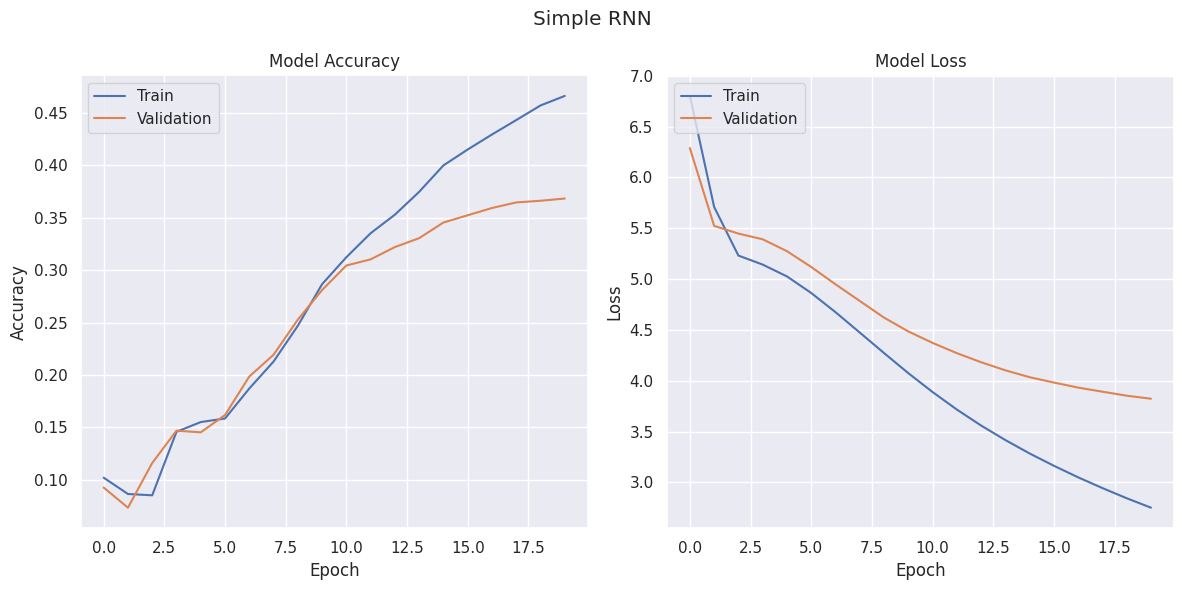

In [93]:
plot_history(history, "Simple RNN")

In [34]:
for seed_text in seed_texts:
    predicted_text = predict_next_word(simple_RNN, seed_text, next_words=10)
    print(predicted_text)
# Example usage
# seed_text = "embrace each day"
# predicted_text = predict_next_word(simple_RNN3, seed_text, next_words=10)
# print(predicted_text)

life 1
from 2
gardens 3
through 4
today 5
the 6
city 7
night 8
star 9
dance 10
radiate 11
our 12
let 13
this 14
every 15
believe 16
nature 17
with 18
island 19
bird 20
embrace 21
in 22
choose 23
gem 24
mold 25
humility 26
an 27
brown 28
crown 29
leave 30
guides 31
understood 32
uplift 33
forest 34
thread 35
blooming 36
solitude 37
brilliance 38
narrative 39
immemorial 40
protects 41
protect 42
village 43
into 44
tending 45
colonial 46
wetlands 47
destination 48
storms 49
evolving 50
stops 51
fulfillment 52
echoing 53
jewels 54
shared 55
days 56
turn 57
old 58
define 59
class 60
ecosystems 61
fulfilled 62
make 63
peace 64
indomitable 65
fort 66
elders 67
thriving 68
navigate 69
success 70
triumphant 71
footprints 72
persevere 73
multiply 74
heart 75
smile 76
witness 77
butterflies 78
beacon 79
guide 80
self 81
contented 82
up 83
road 84
chambers 85
gratitude 86
limitless 87
serene 88
big 89
stages 90
biodiversity 91
ages 92
air 93
stroke 94
simple 95
giving 96
chapters 97
reminds 98
san

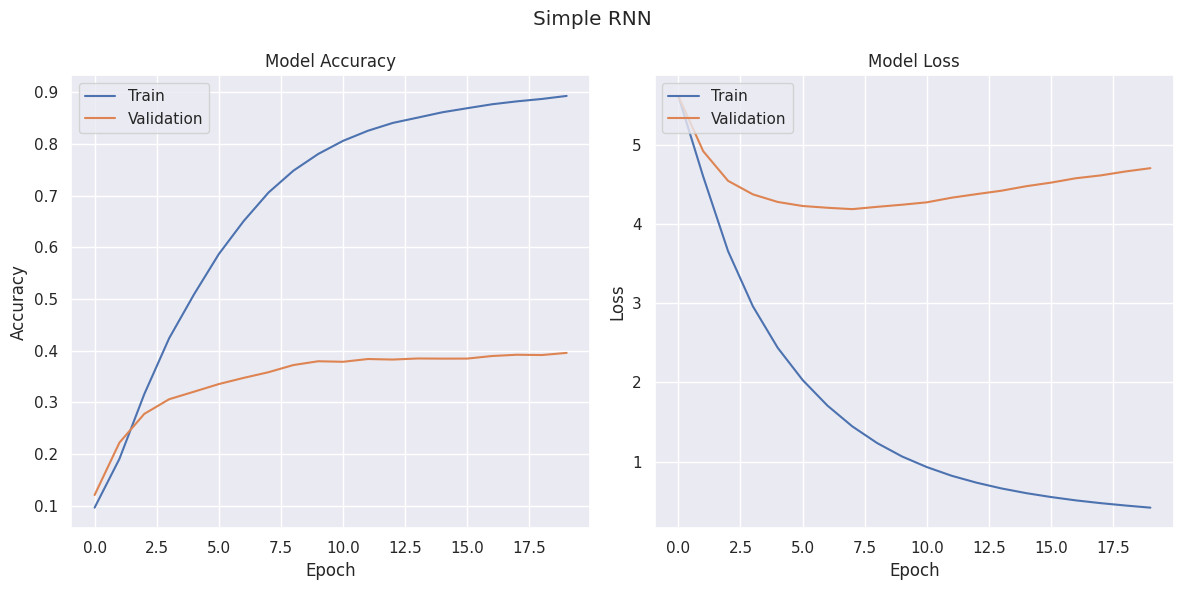

In [98]:
plot_history(history, "Simple RNN")

In [41]:
simple_GRU = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    GRU(64),
    Dense(total_words, activation='softmax')
])
simple_GRU.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

history = fit_model(simple_GRU, "", batch_size=256, epochs=20)

Epoch 1/20
22/22 [==============================] - 3s 87ms/step - loss: 6.9728 - accuracy: 0.1471 - val_loss: 6.6514 - val_accuracy: 0.1491
Epoch 2/20
22/22 [==============================] - 1s 49ms/step - loss: 5.7569 - accuracy: 0.1055 - val_loss: 5.4925 - val_accuracy: 0.0735
Epoch 3/20
22/22 [==============================] - 1s 42ms/step - loss: 5.2320 - accuracy: 0.0906 - val_loss: 5.5130 - val_accuracy: 0.1155
Epoch 4/20
22/22 [==============================] - 1s 39ms/step - loss: 5.1835 - accuracy: 0.1001 - val_loss: 5.5011 - val_accuracy: 0.1299
Epoch 5/20
22/22 [==============================] - 1s 30ms/step - loss: 5.1281 - accuracy: 0.1491 - val_loss: 5.4545 - val_accuracy: 0.1406
Epoch 6/20
22/22 [==============================] - 1s 26ms/step - loss: 5.0442 - accuracy: 0.1509 - val_loss: 5.3720 - val_accuracy: 0.1400
Epoch 7/20
22/22 [==============================] - 0s 22ms/step - loss: 4.9256 - accuracy: 0.1516 - val_loss: 5.2442 - val_accuracy: 0.1422
Epoch 8/20
22

In [42]:
simple_GRU.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 40)                0         
 ctorization)                                                    
                                                                 
 embedding_3 (Embedding)     (None, 40, 768)           907008    
                                                                 
 gru_3 (GRU)                 (None, 64)                160128    
                                                                 
 dense_3 (Dense)             (None, 1181)              76765     
                                                                 
Total params: 1143901 (4.36 MB)
Trainable params: 1143901 (4.36 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


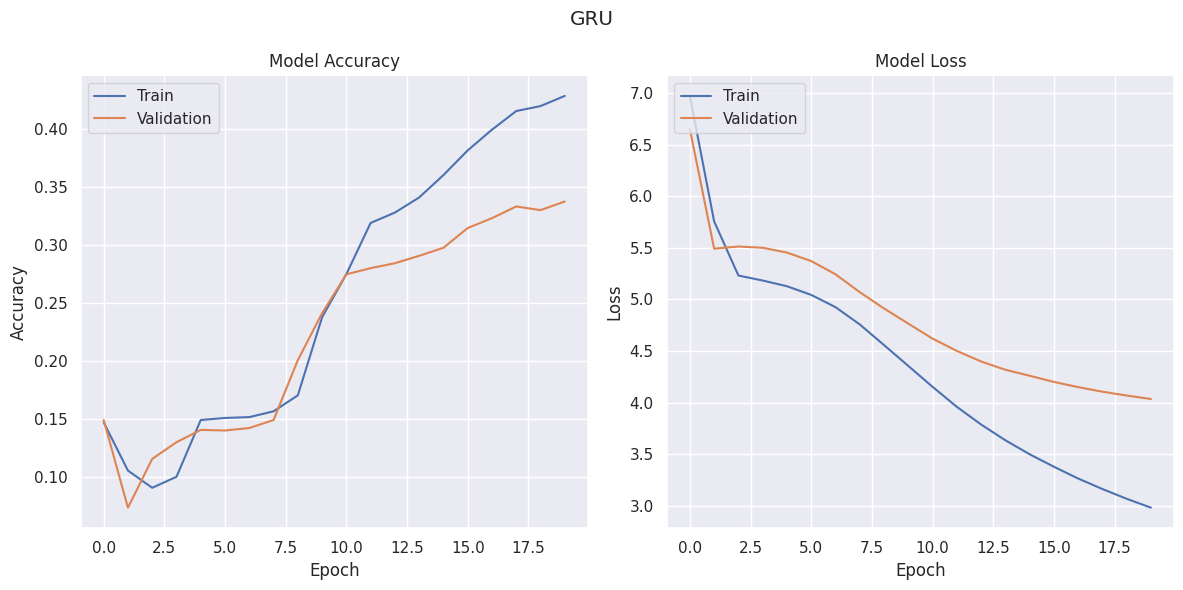

In [43]:
plot_history(history, "GRU")

In [44]:
simple_LSTM = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    LSTM(64),
    Dense(total_words, activation='softmax')
])
simple_LSTM.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

history = fit_model(simple_LSTM, "", batch_size=256, epochs=50)

Epoch 1/20
22/22 [==============================] - 3s 92ms/step - loss: 6.9535 - accuracy: 0.1137 - val_loss: 6.5364 - val_accuracy: 0.0825
Epoch 2/20
22/22 [==============================] - 1s 52ms/step - loss: 5.7950 - accuracy: 0.0611 - val_loss: 5.5303 - val_accuracy: 0.0783
Epoch 3/20
22/22 [==============================] - 1s 41ms/step - loss: 5.2529 - accuracy: 0.0826 - val_loss: 5.5306 - val_accuracy: 0.0783
Epoch 4/20
22/22 [==============================] - 1s 43ms/step - loss: 5.2160 - accuracy: 0.0799 - val_loss: 5.5333 - val_accuracy: 0.0799
Epoch 5/20
22/22 [==============================] - 1s 34ms/step - loss: 5.1918 - accuracy: 0.0856 - val_loss: 5.5195 - val_accuracy: 0.0868
Epoch 6/20
22/22 [==============================] - 1s 30ms/step - loss: 5.1521 - accuracy: 0.0797 - val_loss: 5.4440 - val_accuracy: 0.0825
Epoch 7/20
22/22 [==============================] - 1s 30ms/step - loss: 5.0782 - accuracy: 0.0828 - val_loss: 5.3630 - val_accuracy: 0.0889
Epoch 8/20
22

In [45]:
simple_LSTM.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 40)                0         
 ctorization)                                                    
                                                                 
 embedding_4 (Embedding)     (None, 40, 768)           907008    
                                                                 
 lstm (LSTM)                 (None, 64)                213248    
                                                                 
 dense_4 (Dense)             (None, 1181)              76765     
                                                                 
Total params: 1197021 (4.57 MB)
Trainable params: 1197021 (4.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


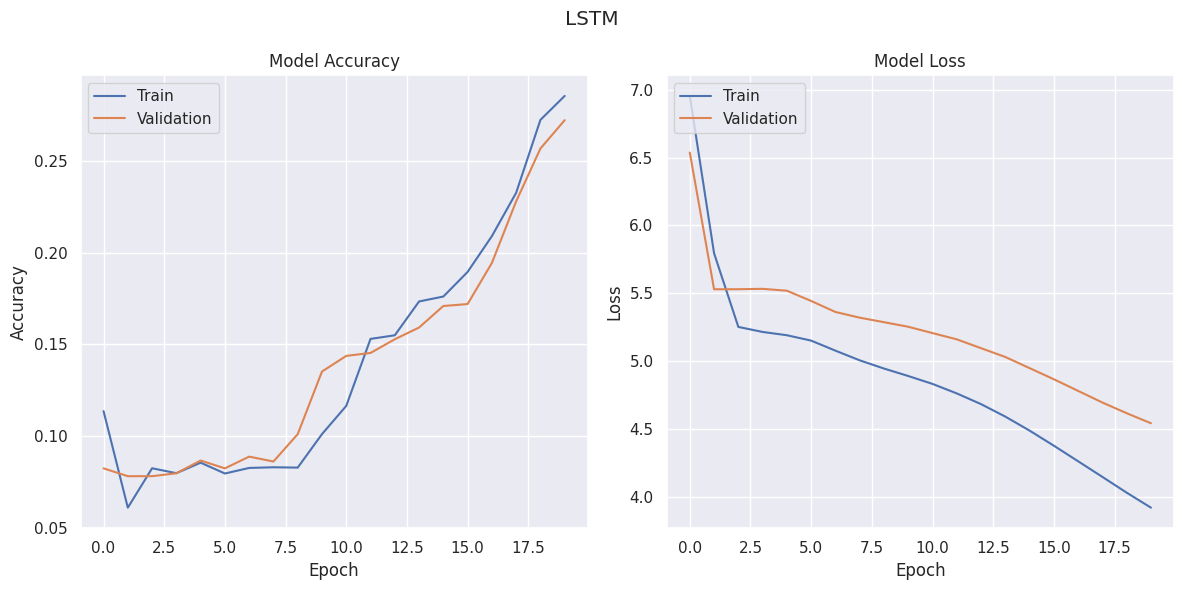

In [46]:
plot_history(history, "LSTM")

* SimpleRNN, LSTM, and GRU all achieve roughly the same accuracy.
* All of the models start overfitting quickly.
* LSTM is able to achieve a higher accuracy before validation loss begins increasing instead of decreasing.

In [49]:
list(X_train)

['Embrace the magic',
 'Embrace the magic in',
 'Embrace the magic in the',
 'Embrace the magic in the ordinary',
 'Embrace the magic in the ordinary it',
 'Embrace the magic in the ordinary it is',
 'Embrace the magic in the ordinary it is the',
 'Embrace the magic in the ordinary it is the heartbeat',
 'Embrace the magic in the ordinary it is the heartbeat of',
 'Embrace the magic in the ordinary it is the heartbeat of a',
 'Embrace the magic in the ordinary it is the heartbeat of a grateful',
 'From Labrador Nature',
 'From Labrador Nature Reserve',
 'From Labrador Nature Reserve is',
 'From Labrador Nature Reserve is rugged',
 'From Labrador Nature Reserve is rugged beauty',
 'From Labrador Nature Reserve is rugged beauty to',
 'From Labrador Nature Reserve is rugged beauty to Jurong',
 'From Labrador Nature Reserve is rugged beauty to Jurong Lake',
 'From Labrador Nature Reserve is rugged beauty to Jurong Lake Gardens',
 'From Labrador Nature Reserve is rugged beauty to Jurong Lak

In [50]:
list(X_validation)

['Radiate forgiveness and',
 'Radiate forgiveness and let',
 'Radiate forgiveness and let it',
 'Radiate forgiveness and let it be',
 'Radiate forgiveness and let it be the',
 'Radiate forgiveness and let it be the bridge',
 'Radiate forgiveness and let it be the bridge that',
 'Radiate forgiveness and let it be the bridge that mends',
 'Singapore is skyline',
 'Singapore is skyline stands',
 'Singapore is skyline stands tall',
 'Singapore is skyline stands tall a',
 'Singapore is skyline stands tall a beacon',
 'Singapore is skyline stands tall a beacon of',
 'Singapore is skyline stands tall a beacon of progress',
 'Singapore is skyline stands tall a beacon of progress and',
 'Let your love',
 'Let your love be',
 'Let your love be the',
 'Let your love be the force',
 'Let your love be the force that',
 'Let your love be the force that heals',
 'Let your love be the force that heals and',
 'Embrace the dance',
 'Embrace the dance of',
 'Embrace the dance of self',
 'Embrace the danc

In [43]:
simple_GRU = Sequential([
    vectorize_layer,
    Embedding(total_words, 768),
    # Flatten(),
    GRU(200, return_sequences=True),
    GRU(200),
    Dense(total_words, activation='softmax')
])

# simple_GRU = Sequential([
#     Embedding(total_words, 10000, input_length=max_sequence_length),
#     # Flatten(),
#     GRU(200, return_sequences=True),
#     GRU(200),
#     Dense(total_words, activation='softmax')
# ])

simple_GRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# history = model.fit(, epochs=50, verbose=1, batch_size=128, validation_data=(X_validation, y_validation))

history = fit_model(simple_GRU, "training_checkpoints/simple_GRU_weights.{epoch:02d}-{val_accuracy:.2f}.h5", batch_size=256, epochs=20)

Epoch 1/20
143/143 [==============================] - 7s 40ms/step - loss: 5.4726 - accuracy: 0.0738 - val_loss: 5.7649 - val_accuracy: 0.0885
Epoch 2/20
143/143 [==============================] - 4s 28ms/step - loss: 5.0367 - accuracy: 0.1329 - val_loss: 5.1396 - val_accuracy: 0.1727
Epoch 3/20
143/143 [==============================] - 4s 28ms/step - loss: 3.8603 - accuracy: 0.2904 - val_loss: 4.4014 - val_accuracy: 0.3066
Epoch 4/20
143/143 [==============================] - 4s 27ms/step - loss: 2.8718 - accuracy: 0.4317 - val_loss: 4.1779 - val_accuracy: 0.3413
Epoch 5/20
143/143 [==============================] - 4s 26ms/step - loss: 2.2062 - accuracy: 0.5307 - val_loss: 4.1460 - val_accuracy: 0.3724
Epoch 6/20
143/143 [==============================] - 4s 27ms/step - loss: 1.7355 - accuracy: 0.6124 - val_loss: 4.1241 - val_accuracy: 0.3993
Epoch 7/20
143/143 [==============================] - 4s 26ms/step - loss: 1.3986 - accuracy: 0.6760 - val_loss: 4.1903 - val_accuracy: 0.4106

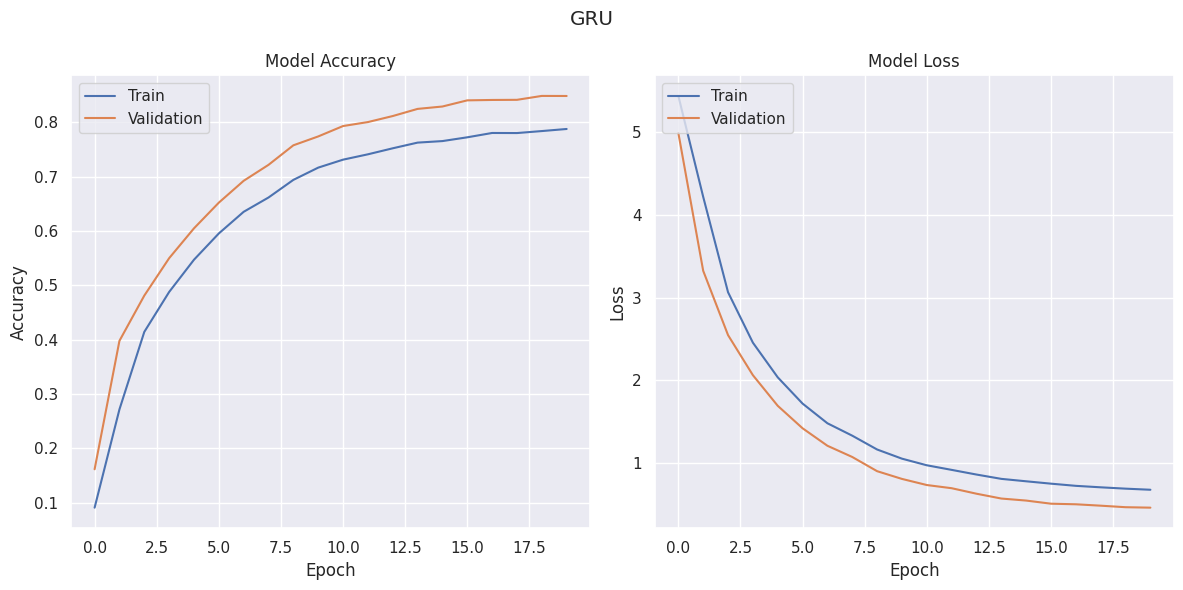

In [274]:
plot_history(history, "GRU")

In [ ]:
simple_GRU = Sequential([
    vectorize_layer,
    Embedding(total_words, 1000),
    # Flatten(),
    GRU(200, return_sequences=True),
    GRU(200),
    Dense(total_words, activation='softmax')
])

# simple_GRU = Sequential([
#     Embedding(total_words, 10000, input_length=max_sequence_length),
#     # Flatten(),
#     GRU(200, return_sequences=True),
#     GRU(200),
#     Dense(total_words, activation='softmax')
# ])

simple_GRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# history = model.fit(, epochs=50, verbose=1, batch_size=128, validation_data=(X_validation, y_validation))

history = fit_model(simple_GRU, "training_checkpoints/simple_GRU_weights.{epoch:02d}-{val_accuracy:.2f}.h5", batch_size=256, epochs=20)

In [316]:
simple_stacked = Sequential([
    vectorize_layer,
    Embedding(total_words, 1000),
    # Flatten(),
    RNN(StackedRNNCells([LSTMCell(32) for _ in range(2)])),
    # Dense(2000, activation="relu"),
    Dense(total_words, activation='softmax')
])

# simple_GRU = Sequential([
#     Embedding(total_words, 10000, input_length=max_sequence_length),
#     # Flatten(),
#     GRU(200, return_sequences=True),
#     GRU(200),
#     Dense(total_words, activation='softmax')
# ])

simple_stacked.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# history = model.fit(, epochs=50, verbose=1, batch_size=128, validation_data=(X_validation, y_validation))

history = fit_model(simple_stacked, "training_checkpoints/simple_GRU_weights.{epoch:02d}-{val_accuracy:.2f}.h5", batch_size=128, epochs=20)

Epoch 1/20
286/286 [==============================] - 84s 290ms/step - loss: 5.5659 - accuracy: 0.0687 - val_loss: 5.6089 - val_accuracy: 0.0885
Epoch 2/20
286/286 [==============================] - 78s 273ms/step - loss: 5.3031 - accuracy: 0.0726 - val_loss: 5.6810 - val_accuracy: 0.0885
Epoch 3/20
286/286 [==============================] - 77s 269ms/step - loss: 5.3010 - accuracy: 0.0743 - val_loss: 5.7247 - val_accuracy: 0.0628
Epoch 4/20
286/286 [==============================] - 77s 270ms/step - loss: 5.2998 - accuracy: 0.0731 - val_loss: 5.7522 - val_accuracy: 0.0628
Epoch 5/20
286/286 [==============================] - 78s 271ms/step - loss: 5.2989 - accuracy: 0.0727 - val_loss: 5.7772 - val_accuracy: 0.0628
Epoch 6/20
286/286 [==============================] - 79s 276ms/step - loss: 5.2979 - accuracy: 0.0758 - val_loss: 5.7843 - val_accuracy: 0.0885
Epoch 7/20
286/286 [==============================] - 80s 279ms/step - loss: 5.2980 - accuracy: 0.0732 - val_loss: 5.8095 - val_ac

KeyboardInterrupt: 

In [198]:
max_vocab_size = 10000

vectorize_layer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=200
)

vectorize_layer.adapt([" ".join(x) for x in tokenized_quotes])

simple_LSTM = Sequential([
    vectorize_layer,
    Embedding(total_words, 100),
    # Flatten(),
    LSTM(200, return_sequences=True),
    LSTM(200),
    Dense(total_words, activation='softmax')
])


simple_LSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
# history = model.fit(, epochs=50, verbose=1, batch_size=128, validation_data=(X_validation, y_validation))

history = fit_model(simple_LSTM, "training_checkpoints/simple_LSTM_weights.{epoch:02d}-{val_accuracy:.2f}.h5", batch_size=256, epochs=20)

Epoch 1/20
 49/241 [=====>........................] - ETA: 57s - loss: 5.6612 - accuracy: 0.0728

KeyboardInterrupt: 

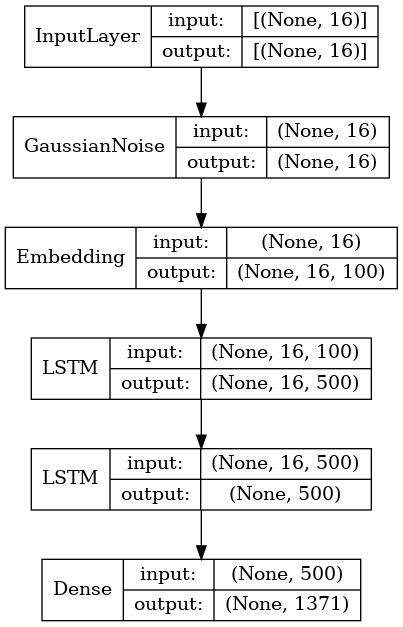

In [117]:
plot_model(simple_RNN, to_file='images/models/simple_LSTM.png', show_shapes=True, show_layer_names=False)

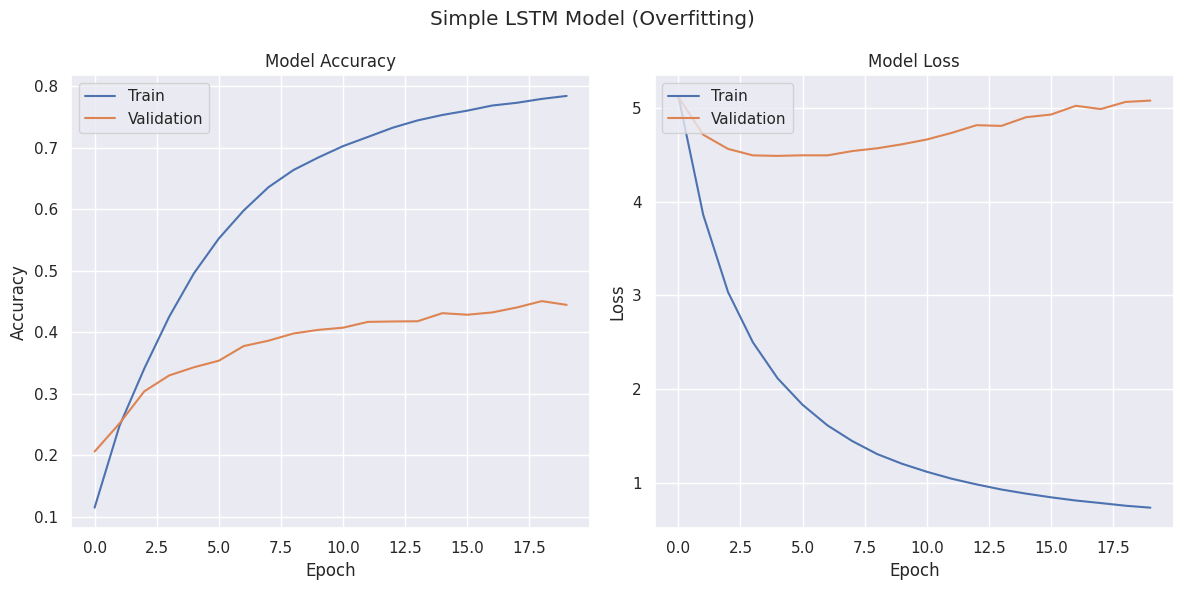

In [104]:
plot_history(history, "Simple LSTM Model (Overfitting)", "images/Simple LSTM Model (Overfitting).png")

* The model is unable to generalise and severely overfits on the training set.

In [45]:
# Attention is all you need

inputs = tf.keras.layers.Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=total_words, output_dim=2000)(inputs)
lstm_layer = GRU(200, return_sequences=True)(embedding_layer)

attention = Attention(use_scale=True)([lstm_layer, lstm_layer])
context_vector = tf.reduce_sum(attention * lstm_layer, axis=1)

output = Dense(total_words, activation='softmax')(context_vector)

attention_model = Model(inputs=inputs, outputs=output)

attention_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = fit_model(attention_model, "training_checkpoints/simple_RNN_weights.{epoch:02d}-{val_accuracy:.2f}.hdf5", epochs=50)

Epoch 1/50
153/153 [==============================] - ETA: 0s - loss: 5.6172 - accuracy: 0.0888
Epoch 1: val_loss improved from inf to 5.49605, saving model to training_checkpoints/simple_RNN_weights.01-0.09.hdf5
153/153 [==============================] - 4s 23ms/step - loss: 5.6172 - accuracy: 0.0888 - val_loss: 5.4960 - val_accuracy: 0.0930
Epoch 2/50
153/153 [==============================] - ETA: 0s - loss: 5.0289 - accuracy: 0.1218
Epoch 2: val_loss improved from 5.49605 to 5.24764, saving model to training_checkpoints/simple_RNN_weights.02-0.14.hdf5
153/153 [==============================] - 2s 12ms/step - loss: 5.0289 - accuracy: 0.1218 - val_loss: 5.2476 - val_accuracy: 0.1417
Epoch 3/50
153/153 [==============================] - ETA: 0s - loss: 4.5129 - accuracy: 0.1549
Epoch 3: val_loss improved from 5.24764 to 5.01739, saving model to training_checkpoints/simple_RNN_weights.03-0.18.hdf5
153/153 [==============================] - 2s 11ms/step - loss: 4.5129 - accuracy: 0.1549

KeyboardInterrupt: 

In [ ]:
attention_model.summary()

In [276]:
# Build the model
simple_RNN3 = Sequential([
    # GaussianNoise(0.5),
    Embedding(total_words, 100, input_length=max_sequence_length),
    Bidirectional(LSTM(50, return_sequences=True)),
    # LSTM(50, return_sequences=True),
    
    Attention(),
    Dropout(0.3),
    Dense(1000),
    Dropout(0.3),
    Dense(total_words, activation='softmax')
])
simple_RNN3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = fit_model(simple_RNN3, "training_checkpoints/simple_RNN_weights.{epoch:02d}-{val_accuracy:.2f}.hdf5", epochs=50)

ValueError: Exception encountered when calling layer "attention_3" (type Attention).

Attention layer must be called on a list of inputs, namely [query, value] or [query, value, key]. Received: Tensor("Placeholder:0", shape=(None, 35, 50), dtype=float32).

Call arguments received by layer "attention_3" (type Attention):
  • inputs=tf.Tensor(shape=(None, 35, 50), dtype=float32)
  • mask=None
  • training=None
  • return_attention_scores=False
  • use_causal_mask=False

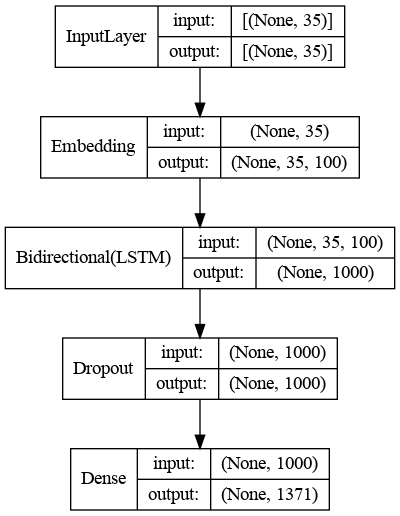

In [260]:
plot_model(simple_RNN3, show_shapes=True, show_layer_names=False)

In [124]:
# Build the model
simple_RNN2 = Sequential([
    GaussianNoise(0.5),
    Embedding(total_words, 100, input_length=max_sequence_length),
    LSTM(100),
    Dropout(0.3),
    Dense(total_words, activation='softmax')
])
simple_RNN2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = fit_model(simple_RNN2, "training_checkpoints/simple_RNN_weights.{epoch:02d}-{val_accuracy:.2f}.hdf5", epochs=20)

Epoch 1/20
389/389 [==============================] - ETA: 0s - loss: 5.3696 - accuracy: 0.0935
Epoch 1: val_loss improved from inf to 5.39246, saving model to training_checkpoints/simple_RNN_weights.01-0.12.hdf5
389/389 [==============================] - 18s 44ms/step - loss: 5.3696 - accuracy: 0.0935 - val_loss: 5.3925 - val_accuracy: 0.1245
Epoch 2/20
388/389 [============================>.] - ETA: 0s - loss: 4.6576 - accuracy: 0.1743
Epoch 2: val_loss improved from 5.39246 to 4.96396, saving model to training_checkpoints/simple_RNN_weights.02-0.21.hdf5
389/389 [==============================] - 15s 38ms/step - loss: 4.6567 - accuracy: 0.1743 - val_loss: 4.9640 - val_accuracy: 0.2063
Epoch 3/20
388/389 [============================>.] - ETA: 0s - loss: 4.1654 - accuracy: 0.2235
Epoch 3: val_loss improved from 4.96396 to 4.73630, saving model to training_checkpoints/simple_RNN_weights.03-0.25.hdf5
389/389 [==============================] - 13s 35ms/step - loss: 4.1646 - accuracy: 0.2

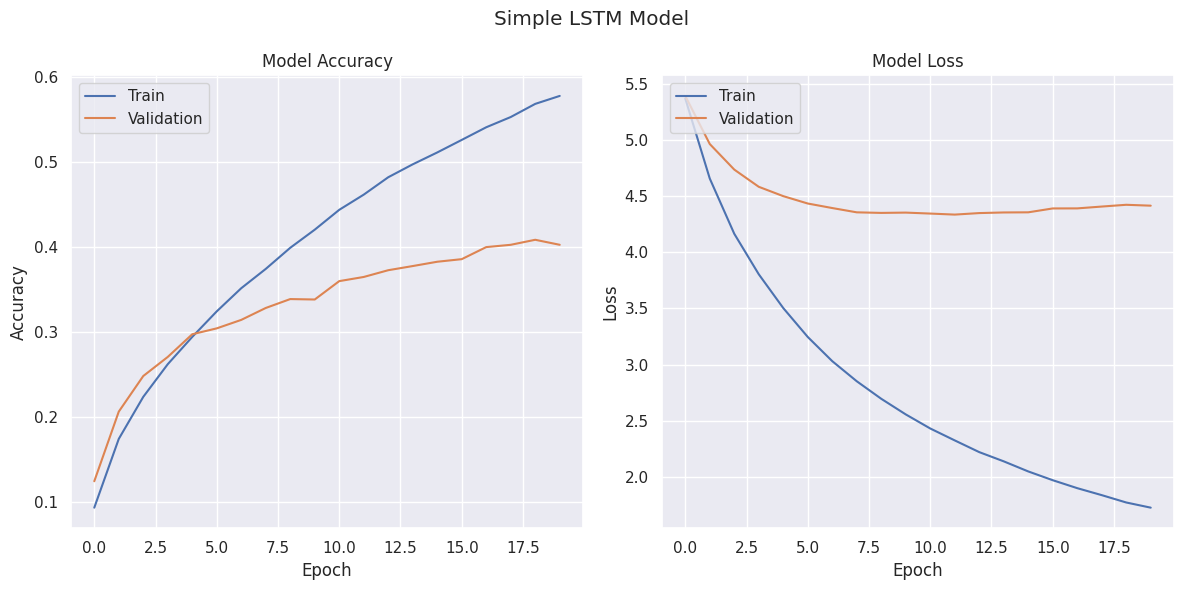

In [125]:
plot_history(history, "Simple LSTM Model")

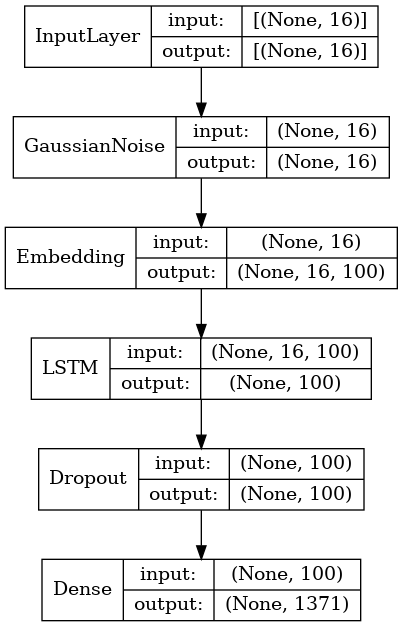

In [126]:
plot_model(simple_RNN2, to_file='images/models/simple_RNN2.png', show_shapes=True, show_layer_names=False)

In [79]:
seed_texts = [
    'embrace each day',
    'radiate some',
    'believe that',
    "life's actual purpose is",
    'dance through each and every',
    'let your time and energy',
    'every person is',
    'our country Singapore is',
    'planet earth is',
    'morning and evening would make it'
]

for seed_text in seed_texts:
    predicted_text = predict_next_word(simple_LSTM, seed_text, next_words=10)
    print(predicted_text)

embrace each day is the of your heart of your heart of your
radiate some the of your heart of your heart of your heart
believe that the of your heart of your heart of your heart
life is actual purpose is the of the of your heart of your heart of
dance through each and every heart of your heart of your heart of your heart
let your time and energy is a of your heart of your heart of the
every person is a is a of the heart of your heart of
our country Singapore is are the are the of your heart of your heart
planet earth is are the of your heart of your heart of your
morning and evening would make it is the of your heart of your heart of your


In [391]:
for seed_text in seed_texts:
    predicted_text = predict_next_word(attention_model, seed_text, next_words=10)
    print(predicted_text)

embrace each day is a canvas for it paint with vibrant heart with
radiate some for it is the heartbeat of your life well lived
believe that yourself for it is the spark that forward forward transformation
life 's actual purpose is a bridge that connects hearts to your future for others
dance through each and every savoring a joyful one one one gift that its time
let your time and energy the ripple that cuts creates doubt connections sun sun meet
every person is a has a power to the world of life 's
our country Singapore is a precious set that words and let go go of
planet earth is the precious heartbeat of our life 's gardens embrace from
morning and evening would make it has the potential to make a difference holds the magic


In [389]:
print("hello")

hello


In [159]:
for seed_text in seed_texts:
    predicted_text = predict_next_word(simple_GRU, seed_text, next_words=10)
    print(predicted_text)

embrace each day is a canvas for new beginnings and fresh opportunities and
radiate some for it is the key to unlocking a bright future
believe that cuts through fear brings your way to success knows no
life 's actual purpose is a step towards miracles the extraordinary moments that defy logic
dance through each and every to navigate your path with purpose and determination shape destinies
let your time and energy flourish hold the keys to your potential and possibility your
every person is marine species protect the treasures of our planet 's future
our country Singapore is a treasure trove singapore 's nature is a sanctuary to
planet earth is a gateway to a brighter future in the realization of
morning and evening would make it 's journey and adventures to the soul from the chains


In [ ]:
# funny preprocessing

In [89]:
for seed_text in seed_texts:
    predicted_text = predict_next_word(simple_RNN, seed_text, next_words=10)
    print(predicted_text)

embrace each day unveil the brilliance of you of the universe a reminder
radiate some lion city kindness defines the community for it is the
believe that you are capable of greatness for they hold the hues
life is actual purpose is biodiversity to jurong lake gardens serenity singapore is nature is
dance through each and every step is a leap of faith this morning find the
let your time and energy with warmth and appreciation a reminder that you are capable
every person is tranquility is a treasure trove of gratitude and watch how
our country Singapore is song is a celebration of every step we take forward
planet earth is ambition and embraces diversity is its strength and strength and
morning and evening would make it is rich with the fruits of love and joy a


In [ ]:
## normal preprocessing

In [94]:
for seed_text in seed_texts:
    predicted_text = predict_next_word(simple_RNN, seed_text, next_words=10)
    print(predicted_text)

embrace each day with the seeds of your heart be the way for
radiate some it is the heartbeat of your heart be the way
believe that this morning find the beauty of the world of this
life is actual purpose is a testament to the beauty of the world of this
dance through each and every it is the heartbeat of your heart be the way
let your time and energy is a testament to the beauty of the world of
every person is a testament to the beauty of the world of this
our country Singapore is savannas are the seeds of your heart be the way
planet earth is forests are the seeds of your heart be the way
morning and evening would make it is the heartbeat of your heart be the way for
